Using device: cuda
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train size: 40000, Val size: 10000, Test size: 10000
Epoch 01/20 | 88.7s | Train Loss 0.5361 Acc 83.01% | Val Loss 0.2390 Acc 91.91%
  ✅ Saved new best model (Val Acc = 91.91%)
Epoch 02/20 | 86.6s | Train Loss 0.2143 Acc 92.94% | Val Loss 0.1810 Acc 93.90%
  ✅ Saved new best model (Val Acc = 93.90%)
Epoch 03/20 | 83.5s | Train Loss 0.1593 Acc 94.80% | Val Loss 0.1569 Acc 94.71%
  ✅ Saved new best model (Val Acc = 94.71%)
Epoch 04/20 | 79.1s | Train Loss 0.1214 Acc 96.01% | Val Loss 0.1412 Acc 95.15%
  ✅ Saved new best model (Val Acc = 95.15%)
Epoch 05/20 | 79.3s | Train Loss 0.0960 Acc 96.97% | Val Loss 0.1387 Acc 95.04%
Epoch 06/20 | 79.8s | Train Loss 0.0785 Acc 97.53% | Val Loss 0.1346 Acc 95.53%
  ✅ Saved new best model (Val Acc = 95.53%)
Epoch 07/20 | 79.8s | Train Loss 0.0639 Acc 98.05% | Val Loss 0.1276 Acc 95.66%
  ✅ Saved new best model (Val Acc = 95.66%)
Epoc

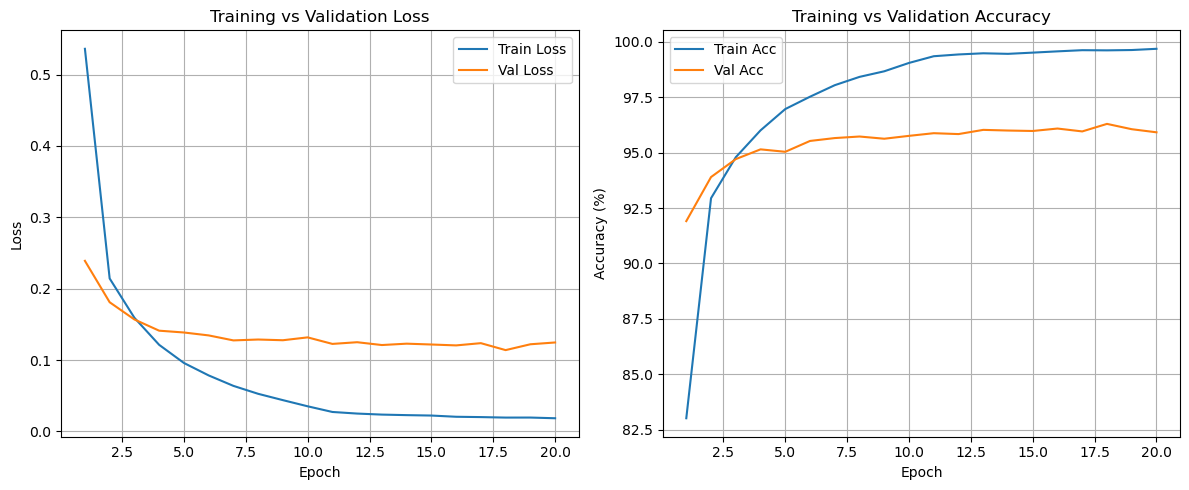


Best checkpoint → Test Loss 0.1403 | Test Acc 95.42%

Classification report:
              precision    recall  f1-score   support

    airplane       0.95      0.98      0.96      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.95      0.94      0.95      1000
         cat       0.92      0.89      0.90      1000
        deer       0.96      0.96      0.96      1000
         dog       0.90      0.93      0.91      1000
        frog       0.98      0.99      0.98      1000
       horse       0.98      0.95      0.96      1000
        ship       0.97      0.97      0.97      1000
       truck       0.97      0.97      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



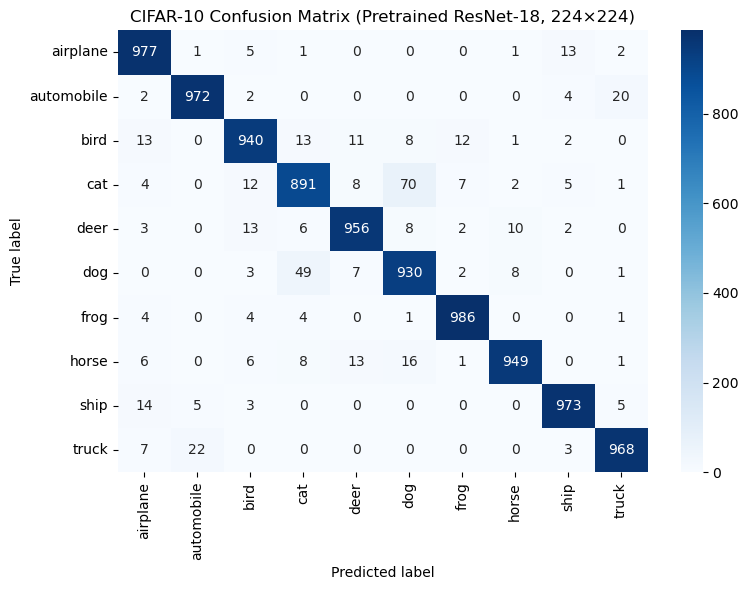

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import time
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

########################################
# 0. Device
########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 1. Transforms (224×224 for pretrained backbone)
########################################
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

########################################
# 2. Load CIFAR-10
########################################
data_root = r"C:\Users\ADMIN\Downloads\cifar-10-python.tar\cifar-10-python"

full_train_dataset = torchvision.datasets.CIFAR10(
    root=data_root, train=True, transform=train_transform, download=False
)
test_dataset = torchvision.datasets.CIFAR10(
    root=data_root, train=False, transform=test_transform, download=False
)
classes = full_train_dataset.classes
print("Classes:", classes)

########################################
# 3. Split 50 000 → 40 000 train / 10 000 val
########################################
VAL_SPLIT = 0.2
n_train = int((1 - VAL_SPLIT) * len(full_train_dataset))
n_val = len(full_train_dataset) - n_train
g = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [n_train, n_val], generator=g)
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

########################################
# 4. Dataloaders
########################################
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

########################################
# 5. Pretrained ResNet-18 (ImageNet)
########################################
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

########################################
# 6. Loss, Optimizer, Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

########################################
# 7. Train / Eval helpers
########################################
def train_one_epoch(model, loader):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    all_y, all_pred = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        loss_sum += loss.item() * y.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        all_y.append(y.cpu()); all_pred.append(pred.cpu())
    all_y = torch.cat(all_y); all_pred = torch.cat(all_pred)
    return loss_sum / total, correct / total, all_y, all_pred

########################################
# 8. Training loop (Train / Val curves)
########################################
EPOCHS = 20
best_val = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)
    scheduler.step()

    train_losses.append(tr_loss); val_losses.append(val_loss)
    train_accs.append(tr_acc);   val_accs.append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | {time.time()-t0:.1f}s | "
          f"Train Loss {tr_loss:.4f} Acc {tr_acc*100:.2f}% | "
          f"Val Loss {val_loss:.4f} Acc {val_acc*100:.2f}%")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), "resnet18_cifar10_pretrained224_best.pth")
        print(f"  ✅ Saved new best model (Val Acc = {best_val*100:.2f}%)")

print(f"\nTraining complete. Best Val Acc: {best_val*100:.2f}%")

########################################
# 9. Plot Train vs Val Accuracy & Loss
########################################
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_range, [a*100 for a in train_accs], label='Train Acc')
plt.plot(epochs_range, [a*100 for a in val_accs], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Training vs Validation Accuracy')
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

########################################
# 10. Final Test Evaluation (Unseen)
########################################
best_model = resnet18(weights=None)
best_model.fc = nn.Linear(best_model.fc.in_features, 10)
best_model = best_model.to(device)
best_model.load_state_dict(torch.load("resnet18_cifar10_pretrained224_best.pth", map_location=device))

test_loss, test_acc, y_true, y_pred = eval_epoch(best_model, test_loader)
print(f"\nBest checkpoint → Test Loss {test_loss:.4f} | Test Acc {test_acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_true.numpy(), y_pred.numpy(), target_names=classes))

########################################
# 11. Confusion Matrix
########################################
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted label"); plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Pretrained ResNet-18, 224×224)")
plt.tight_layout(); plt.show()



Collected 25 misclassified samples to display.


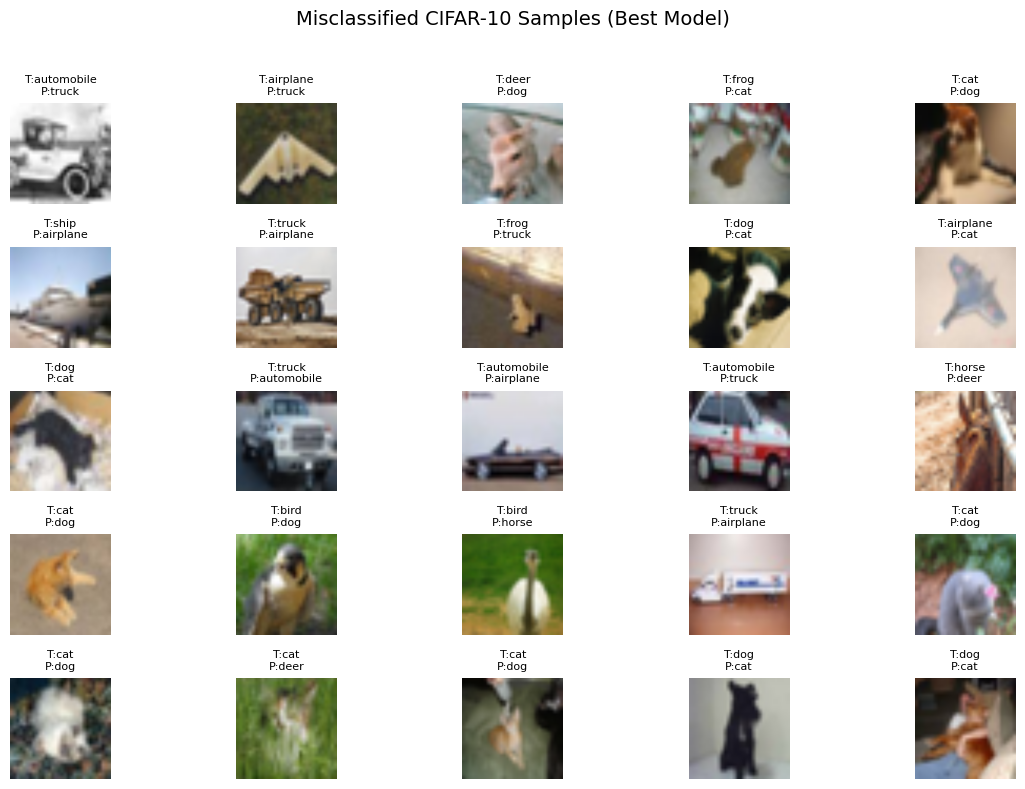

In [2]:
########################################
# 12. Show some misclassified samples
########################################

# Helper to denormalize for visualization
inv_mean = torch.tensor(imagenet_mean).view(3, 1, 1)
inv_std = torch.tensor(imagenet_std).view(3, 1, 1)

def denorm(img_tensor):
    # img_tensor: (3, H, W) normalized
    return (img_tensor * inv_std + inv_mean).clamp(0, 1)

mis_images = []
mis_true = []
mis_pred = []

best_model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = best_model(imgs)
        preds = outputs.argmax(dim=1)

        mismatch = preds != labels
        if mismatch.any():
            # Select only misclassified ones
            wrong_imgs = imgs[mismatch]
            wrong_true = labels[mismatch]
            wrong_pred = preds[mismatch]

            for i in range(wrong_imgs.size(0)):
                mis_images.append(wrong_imgs[i].cpu())
                mis_true.append(wrong_true[i].item())
                mis_pred.append(wrong_pred[i].item())

                # limit how many we store/display
                if len(mis_images) >= 25:
                    break
        if len(mis_images) >= 25:
            break

print(f"\nCollected {len(mis_images)} misclassified samples to display.")

# Plot a grid of misclassified examples
if mis_images:
    plt.figure(figsize=(12, 8))
    for idx in range(len(mis_images)):
        plt.subplot(5, 5, idx + 1)
        img = denorm(mis_images[idx])          # (3, H, W)
        img = img.permute(1, 2, 0).numpy()     # (H, W, 3)
        true_label = classes[mis_true[idx]]
        pred_label = classes[mis_pred[idx]]
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{true_label}\nP:{pred_label}", fontsize=8)
    plt.suptitle("Misclassified CIFAR-10 Samples (Best Model)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No misclassified samples found (suspiciously perfect 😅).")



Per-class performance:
Class             Accuracy   Error Rate    Precision     Recall   F1-score
airplane             97.70%         2.30%        94.85%      97.70%      96.26%
automobile           97.20%         2.80%        97.20%      97.20%      97.20%
bird                 94.00%         6.00%        95.14%      94.00%      94.57%
cat                  89.10%        10.90%        91.67%      89.10%      90.37%
deer                 95.60%         4.40%        96.08%      95.60%      95.84%
dog                  93.00%         7.00%        90.03%      93.00%      91.49%
frog                 98.60%         1.40%        97.62%      98.60%      98.11%
horse                94.90%         5.10%        97.73%      94.90%      96.30%
ship                 97.30%         2.70%        97.11%      97.30%      97.20%
truck                96.80%         3.20%        96.90%      96.80%      96.85%


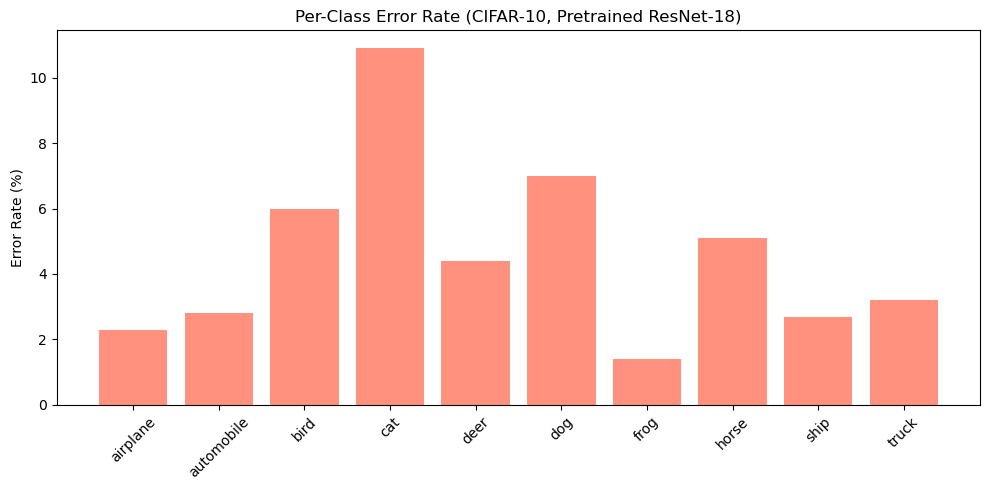

In [3]:
########################################
# 13. Per-Class Error Analysis
########################################

import numpy as np

# Compute per-class accuracy, error rate, precision, recall, F1
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())
per_class_total = cm.sum(axis=1)
per_class_correct = np.diag(cm)
per_class_acc = per_class_correct / per_class_total
per_class_err = 1 - per_class_acc

print("\nPer-class performance:")
print(f"{'Class':15s} {'Accuracy':>10s} {'Error Rate':>12s} {'Precision':>12s} {'Recall':>10s} {'F1-score':>10s}")

report = classification_report(y_true.numpy(), y_pred.numpy(), target_names=classes, output_dict=True)

for i, cls in enumerate(classes):
    prec = report[cls]['precision']
    rec  = report[cls]['recall']
    f1   = report[cls]['f1-score']
    print(f"{cls:15s} {per_class_acc[i]*100:10.2f}% {per_class_err[i]*100:12.2f}% {prec*100:12.2f}% {rec*100:10.2f}% {f1*100:10.2f}%")

# Optional: Bar chart of per-class error
plt.figure(figsize=(10,5))
plt.bar(classes, per_class_err*100, color='tomato', alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel('Error Rate (%)')
plt.title('Per-Class Error Rate (CIFAR-10, Pretrained ResNet-18)')
plt.tight_layout()
plt.show()
